In [21]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import warnings
import sys,os
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 0
from tqdm import tqdm
plt.rcParams['figure.dpi'] = 300

# E9.5 Primordial germ cell plots

### Load and Aggregate based on Metacells

In [2]:
ob0 = pd.read_pickle(f'E95_metacells.pkl')

In [3]:
a0 = sc.read_h5ad('E95_full.h5ad')

In [4]:
def aggregate_based_on_metacells(a0, path):
    ob = pd.read_pickle(f'{path}.pkl')
    ts = path[:3]
    ss = sorted(set(ob['metacell']))

    Ds = {}
    for s in ss:
        Ds[s] = []

    inds = ob.index
    seacells = ob['metacell']
    for i,s in zip(inds, seacells):
        Ds[s].append(i)
    Dsi = dict(zip(ob.index, ob['metacell']))

    a0 = a0[inds].copy()
    a0.obs['metacell'] = a0.obs.index.map(Dsi)
    # I need to aggregate X and obsm['X_pcaS']

    xs = []
    pcas = []
    cts = []

    for s in sorted(set(seacells)):
        a_sub = a0[a0.obs['metacell']==s].copy()
        xs.append(a_sub.X.A.mean(0).flatten())
        pcas.append(a_sub.obsm['X_pcaS'].mean(0).flatten())
        vc = a_sub.obs['cell_type'].value_counts()
        max_cells = vc.iloc[0]
        # pick the cell type from the max, taking one randomly if there are two celltypes with the exact same
        # numbers of cell
        cts.append(np.random.choice(vc[vc==max_cells].index))
    a_new = anndata.AnnData(X=np.vstack(xs))
    a_new.obs.index = sorted(set(seacells))
    a_new.obsm['X_pcaS'] = np.vstack(pcas)
    a_new.obs['cell_type'] = cts
    a_new.var = a0.var.copy()
    return(a_new, Ds, Dsi)

In [5]:
a0n, _, _ = aggregate_based_on_metacells(a0, 'E95_metacells')

In [6]:
# Compute a joint UMAP

In [7]:
a0.obs['set'] = 'single_cell'
a0n.obs['set'] = 'metacells'
ac = anndata.concat([a0, a0n])
ac.obs['set']=ac.obs['set'].astype('category')

/home/manu/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
sc.pp.neighbors(ac, use_rep='X_pcaS')

In [9]:
sc.tl.umap(ac)

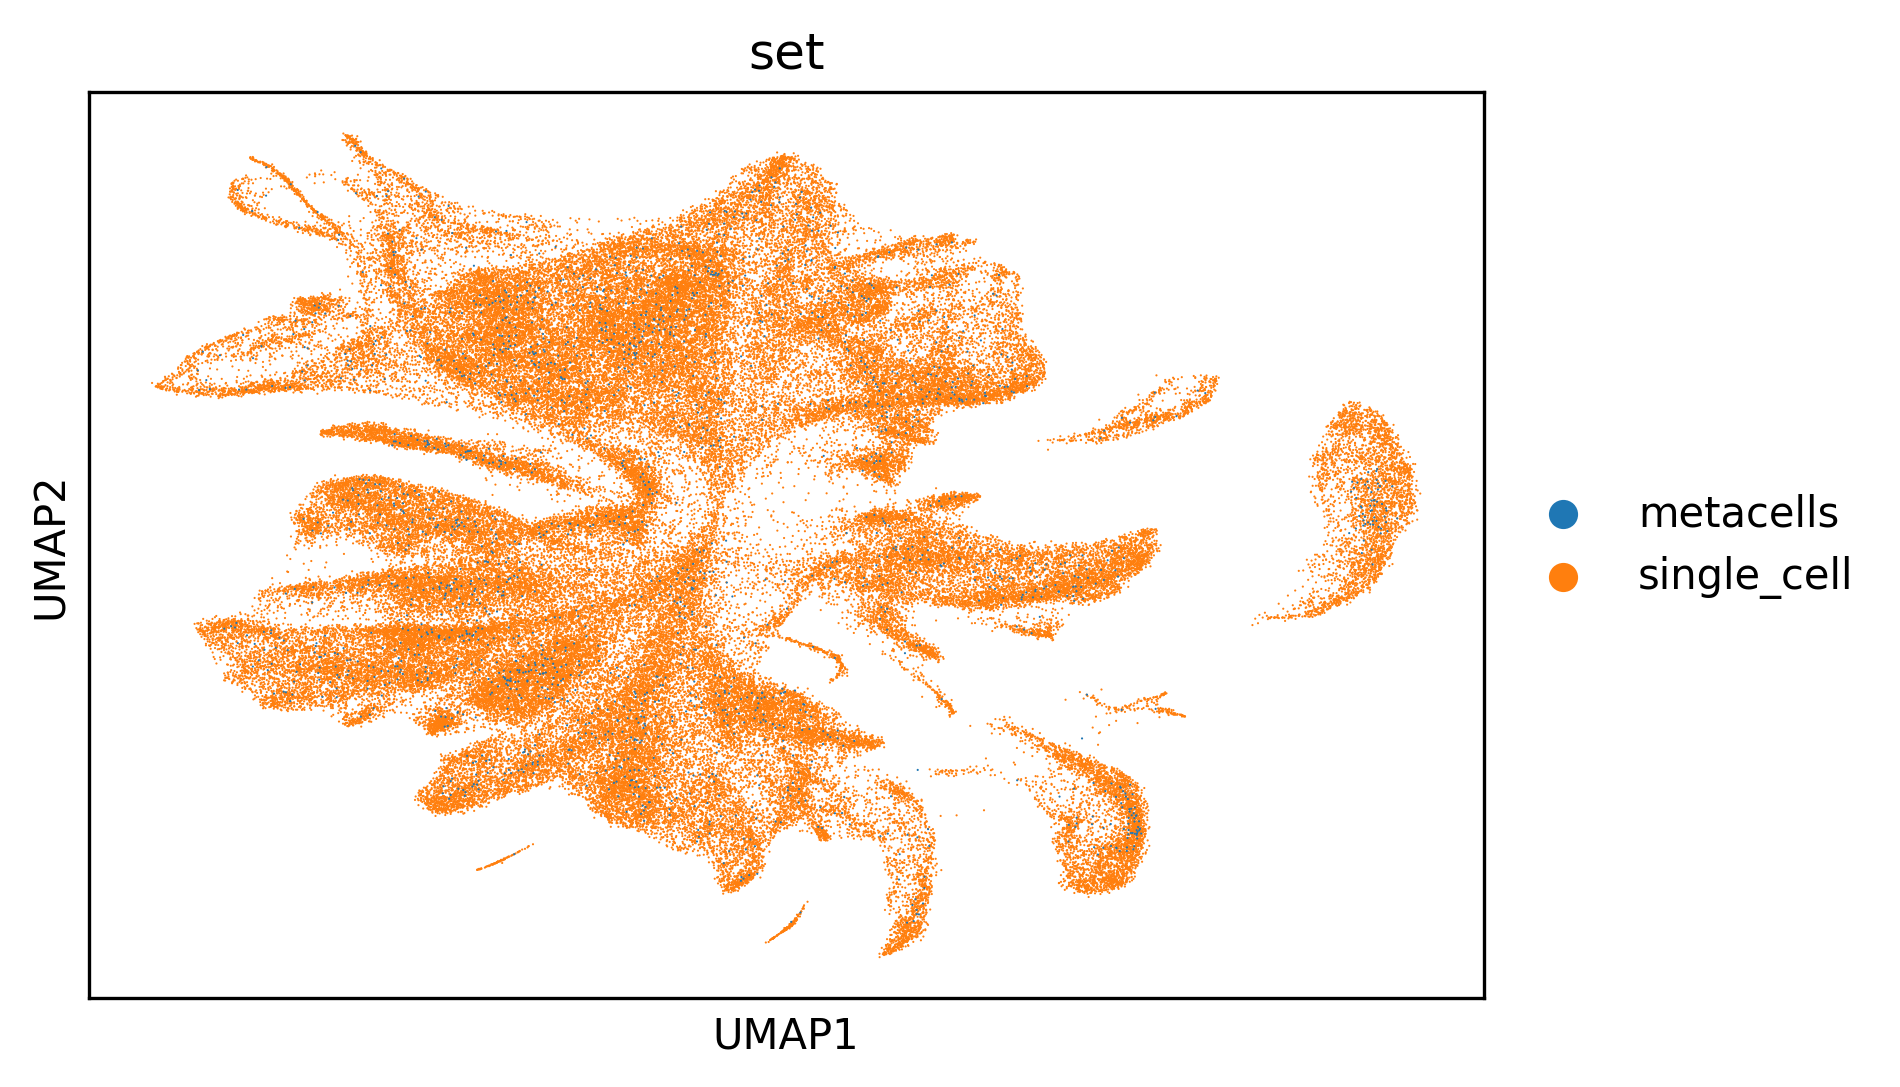

In [22]:
plt.rcParams['figure.dpi'] = 300
sc.pl.umap(ac, color='set')

/home/manu/.local/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


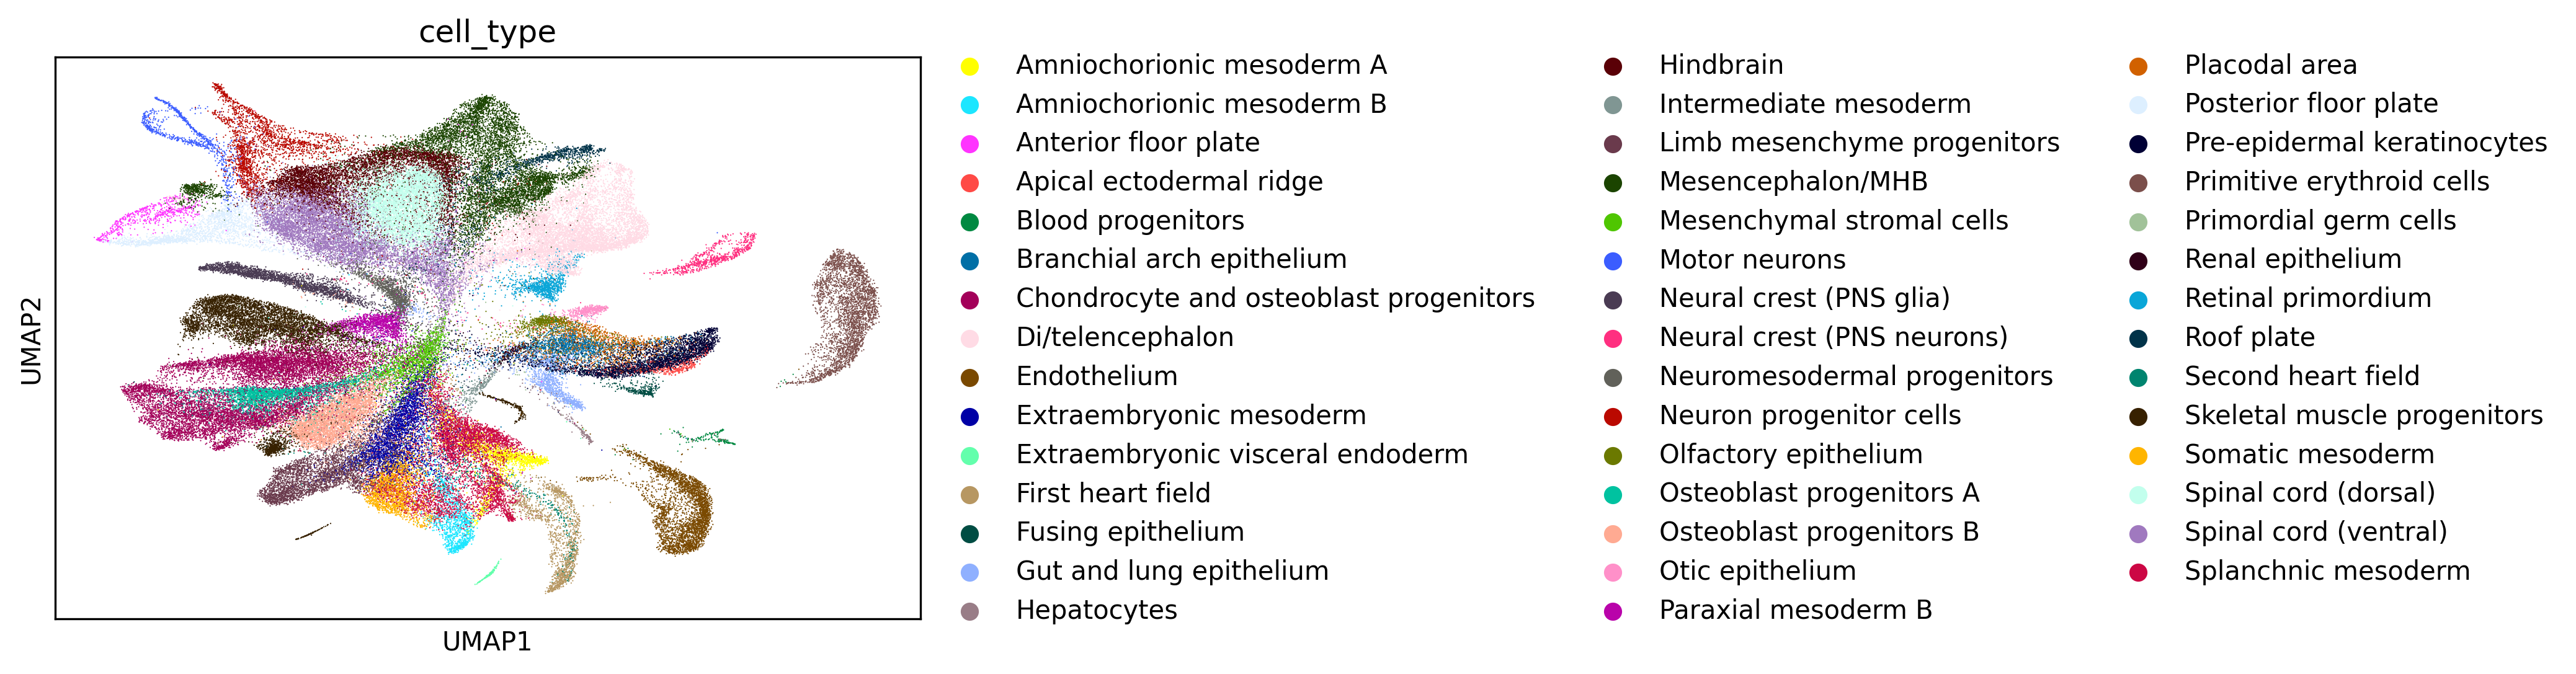

In [23]:
sc.pl.umap(ac[ac.obs['set']=='single_cell'], color='cell_type')

/home/manu/.local/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


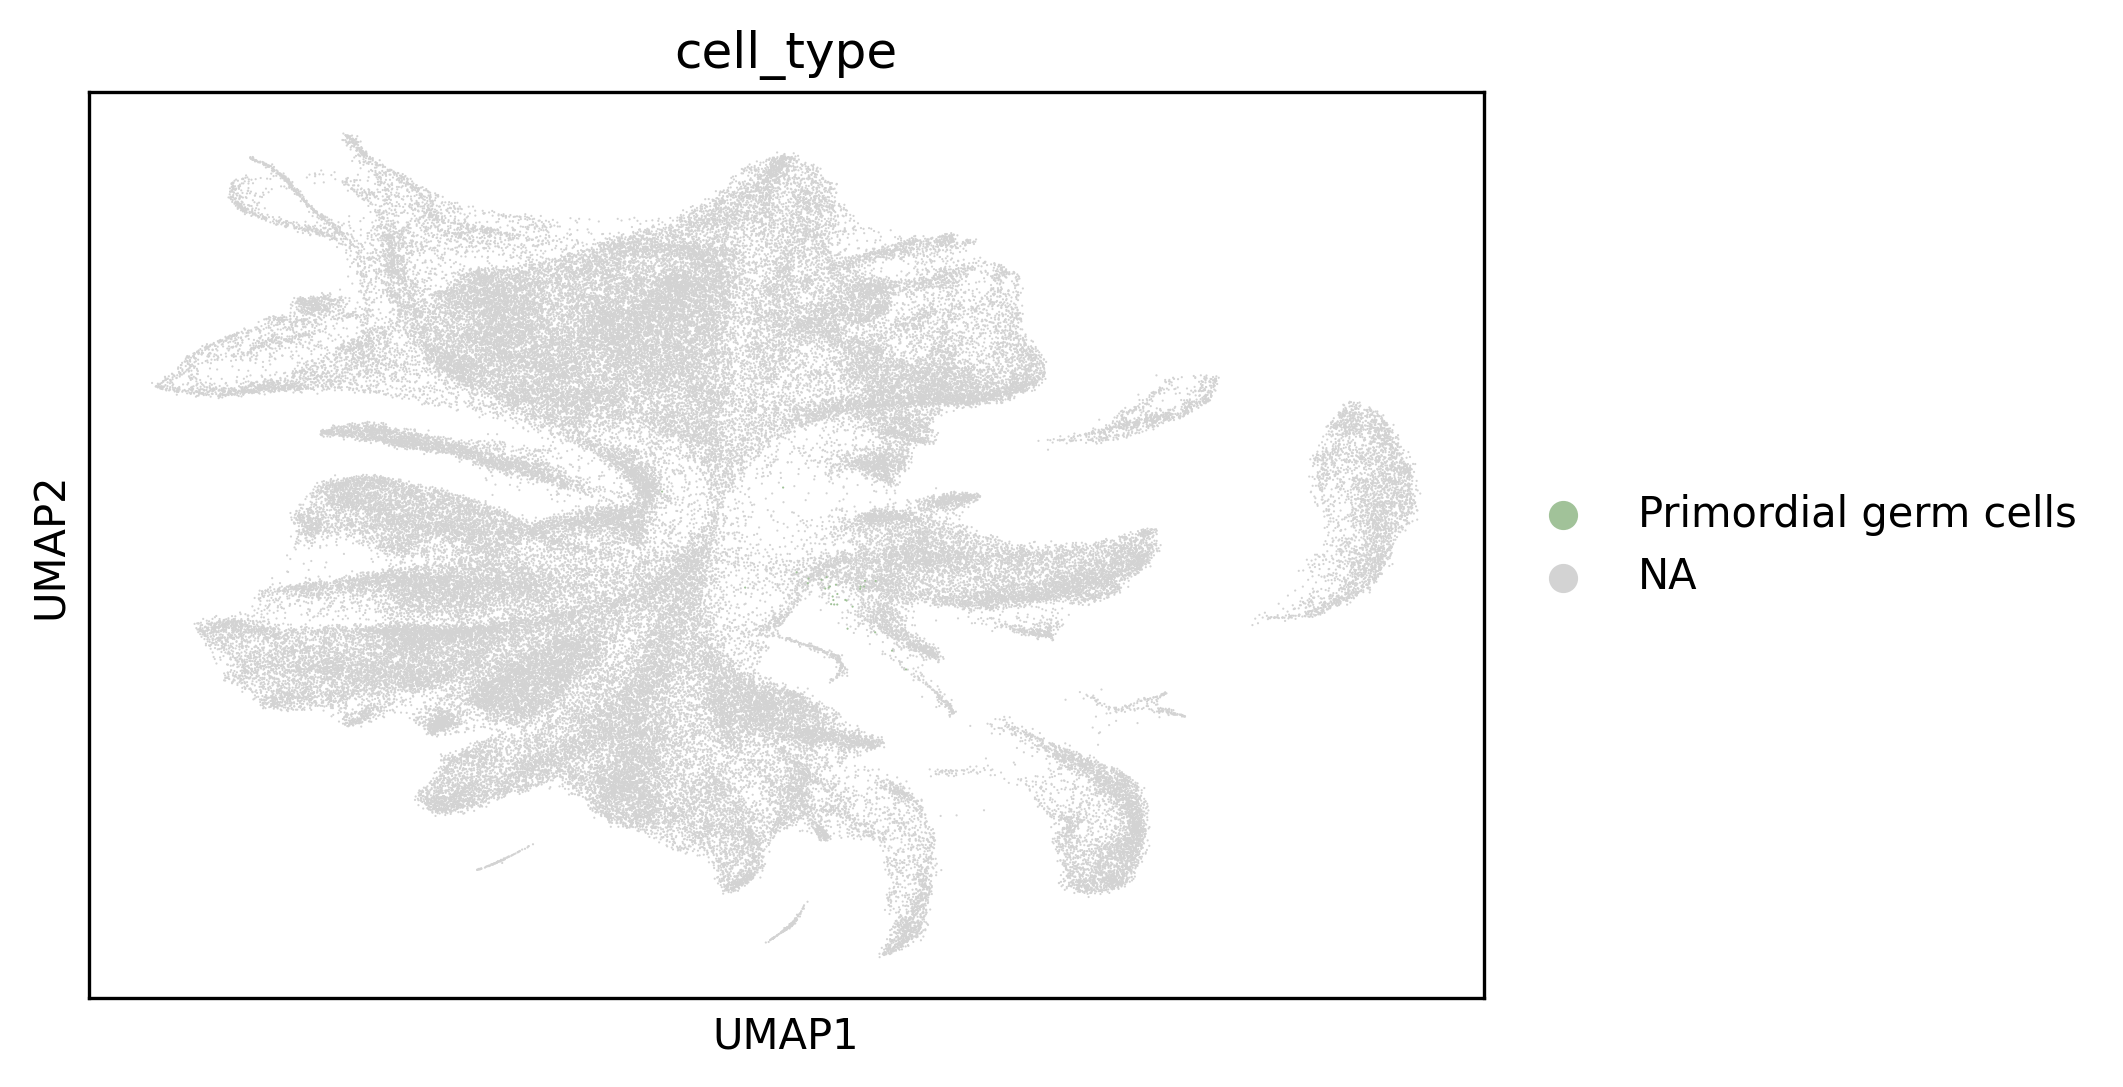

In [24]:
sc.pl.umap(ac[ac.obs['set']=='single_cell'], color='cell_type', groups = ['Primordial germ cells'])

In [25]:
ct_keep = ['Primordial germ cells', 'Gut and lung epithelium', 'Pre-epidermal keratinocytes', 'Branchial arch epithelium',
          'Fusing epithelium', 'Hepatocytes', 'Intermediate mesoderm', 'Apical ectodermal ridge',
          'Placodal area', 'Otic epithelium', 'Olfactory epithelium', 'Renal epithelium']

/home/manu/.local/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


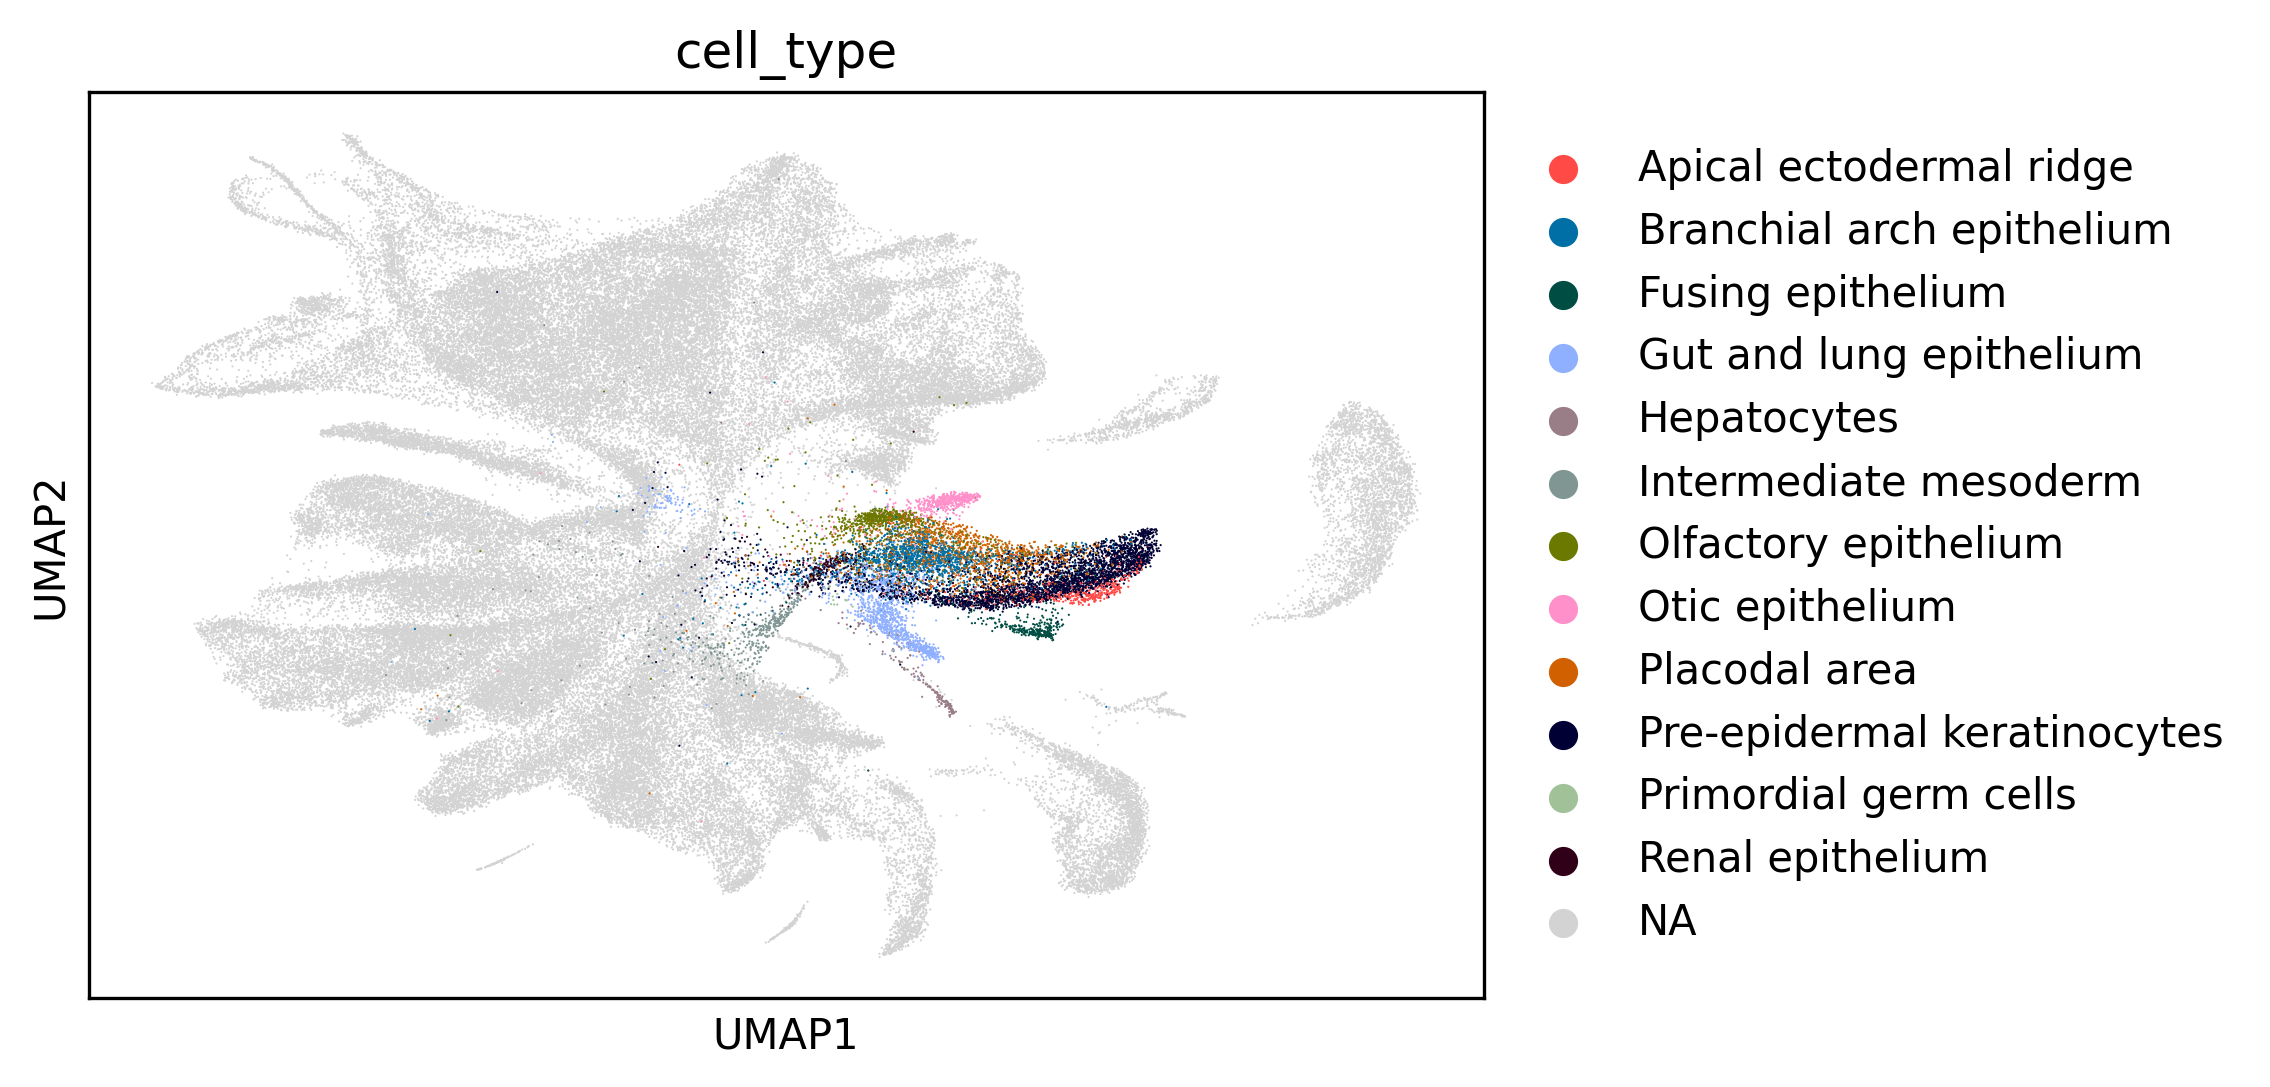

In [26]:
sc.pl.umap(ac[ac.obs['set']=='single_cell'], color='cell_type', groups = ct_keep)

In [27]:
ac.obs['Celltype'] = [a if a in ct_keep else 'Other' for a in ac.obs['cell_type']]
ac.obs['Celltype'] = pd.Categorical(ac.obs['Celltype'], categories=ct_keep+['Other'], ordered=True)

In [28]:
ac.obs['x']=ac.obsm['X_umap'][:,0]
ac.obs['y']=ac.obsm['X_umap'][:,1]

In [29]:
palette = sns.color_palette('tab20')

In [30]:
palette[12] = palette[14]

/tmp/ipykernel_5543/1282834993.py:1: UserWarning: The palette list has more values (20) than needed (13), which may not be intended.
  sns.scatterplot(data=ac.obs[ac.obs['set']=='single_cell'], x='x', y='y', s=0.5, hue='Celltype', palette=palette, legend=None)
/tmp/ipykernel_5543/1282834993.py:2: UserWarning: The palette list has more values (20) than needed (13), which may not be intended.
  sns.scatterplot(data=ac.obs[ac.obs['set']=='metacells'], x='x', y='y', s=5, hue='Celltype', palette=palette, edgecolor='k')


Text(0, 0.5, 'UMAP 2')

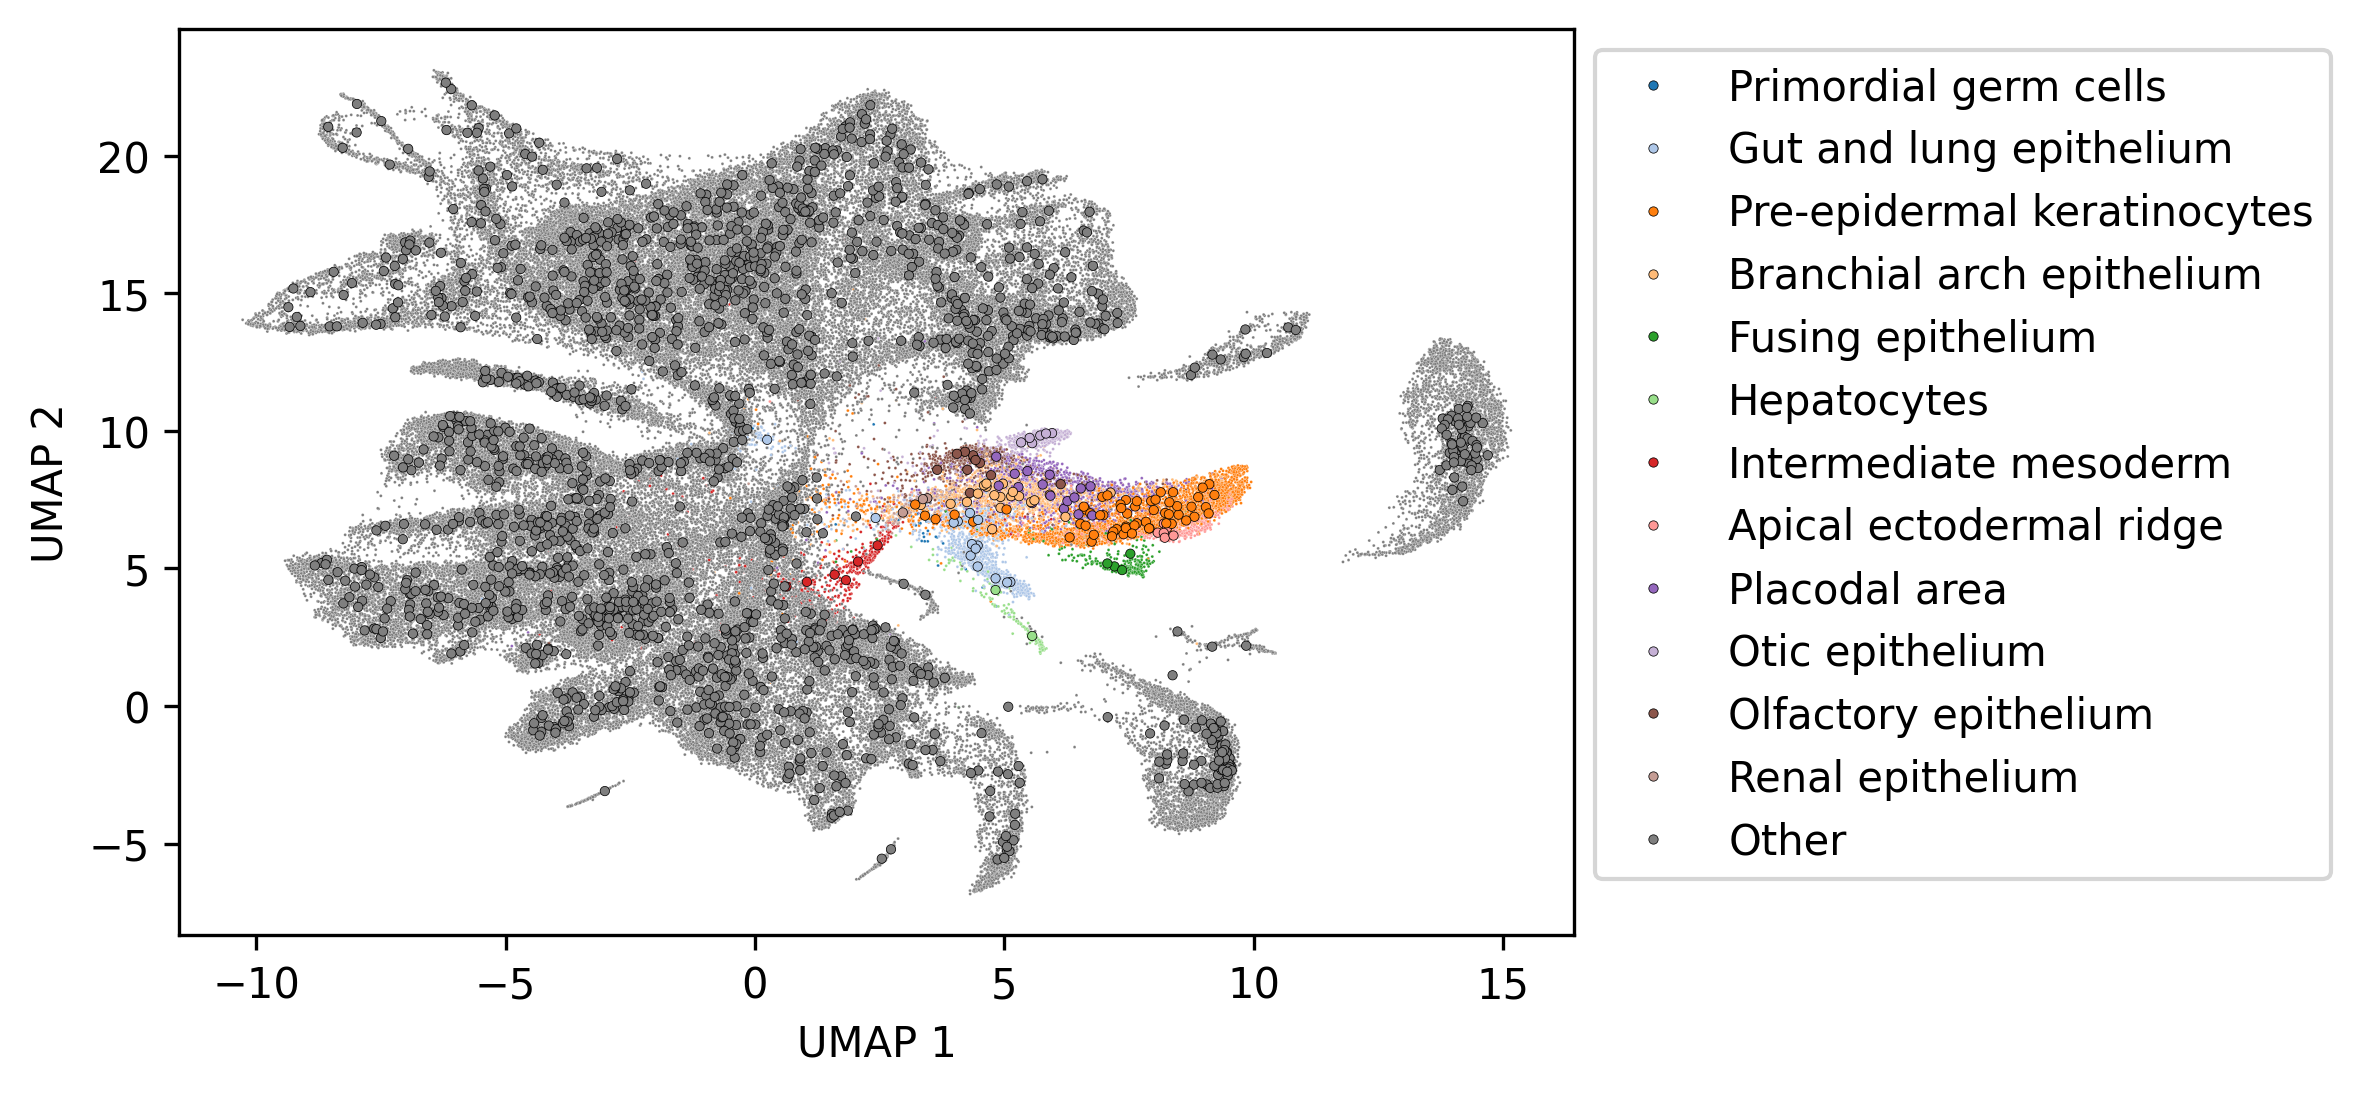

In [31]:
sns.scatterplot(data=ac.obs[ac.obs['set']=='single_cell'], x='x', y='y', s=0.5, hue='Celltype', palette=palette, legend=None)
sns.scatterplot(data=ac.obs[ac.obs['set']=='metacells'], x='x', y='y', s=5, hue='Celltype', palette=palette, edgecolor='k')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

/tmp/ipykernel_5543/327225946.py:2: UserWarning: The palette list has more values (20) than needed (13), which may not be intended.
  sns.scatterplot(data=ac.obs[ac.obs['set']=='metacells'], x='x', y='y', s=50, hue='Celltype', palette=palette, edgecolor='k')


Text(0, 0.5, 'UMAP 2')

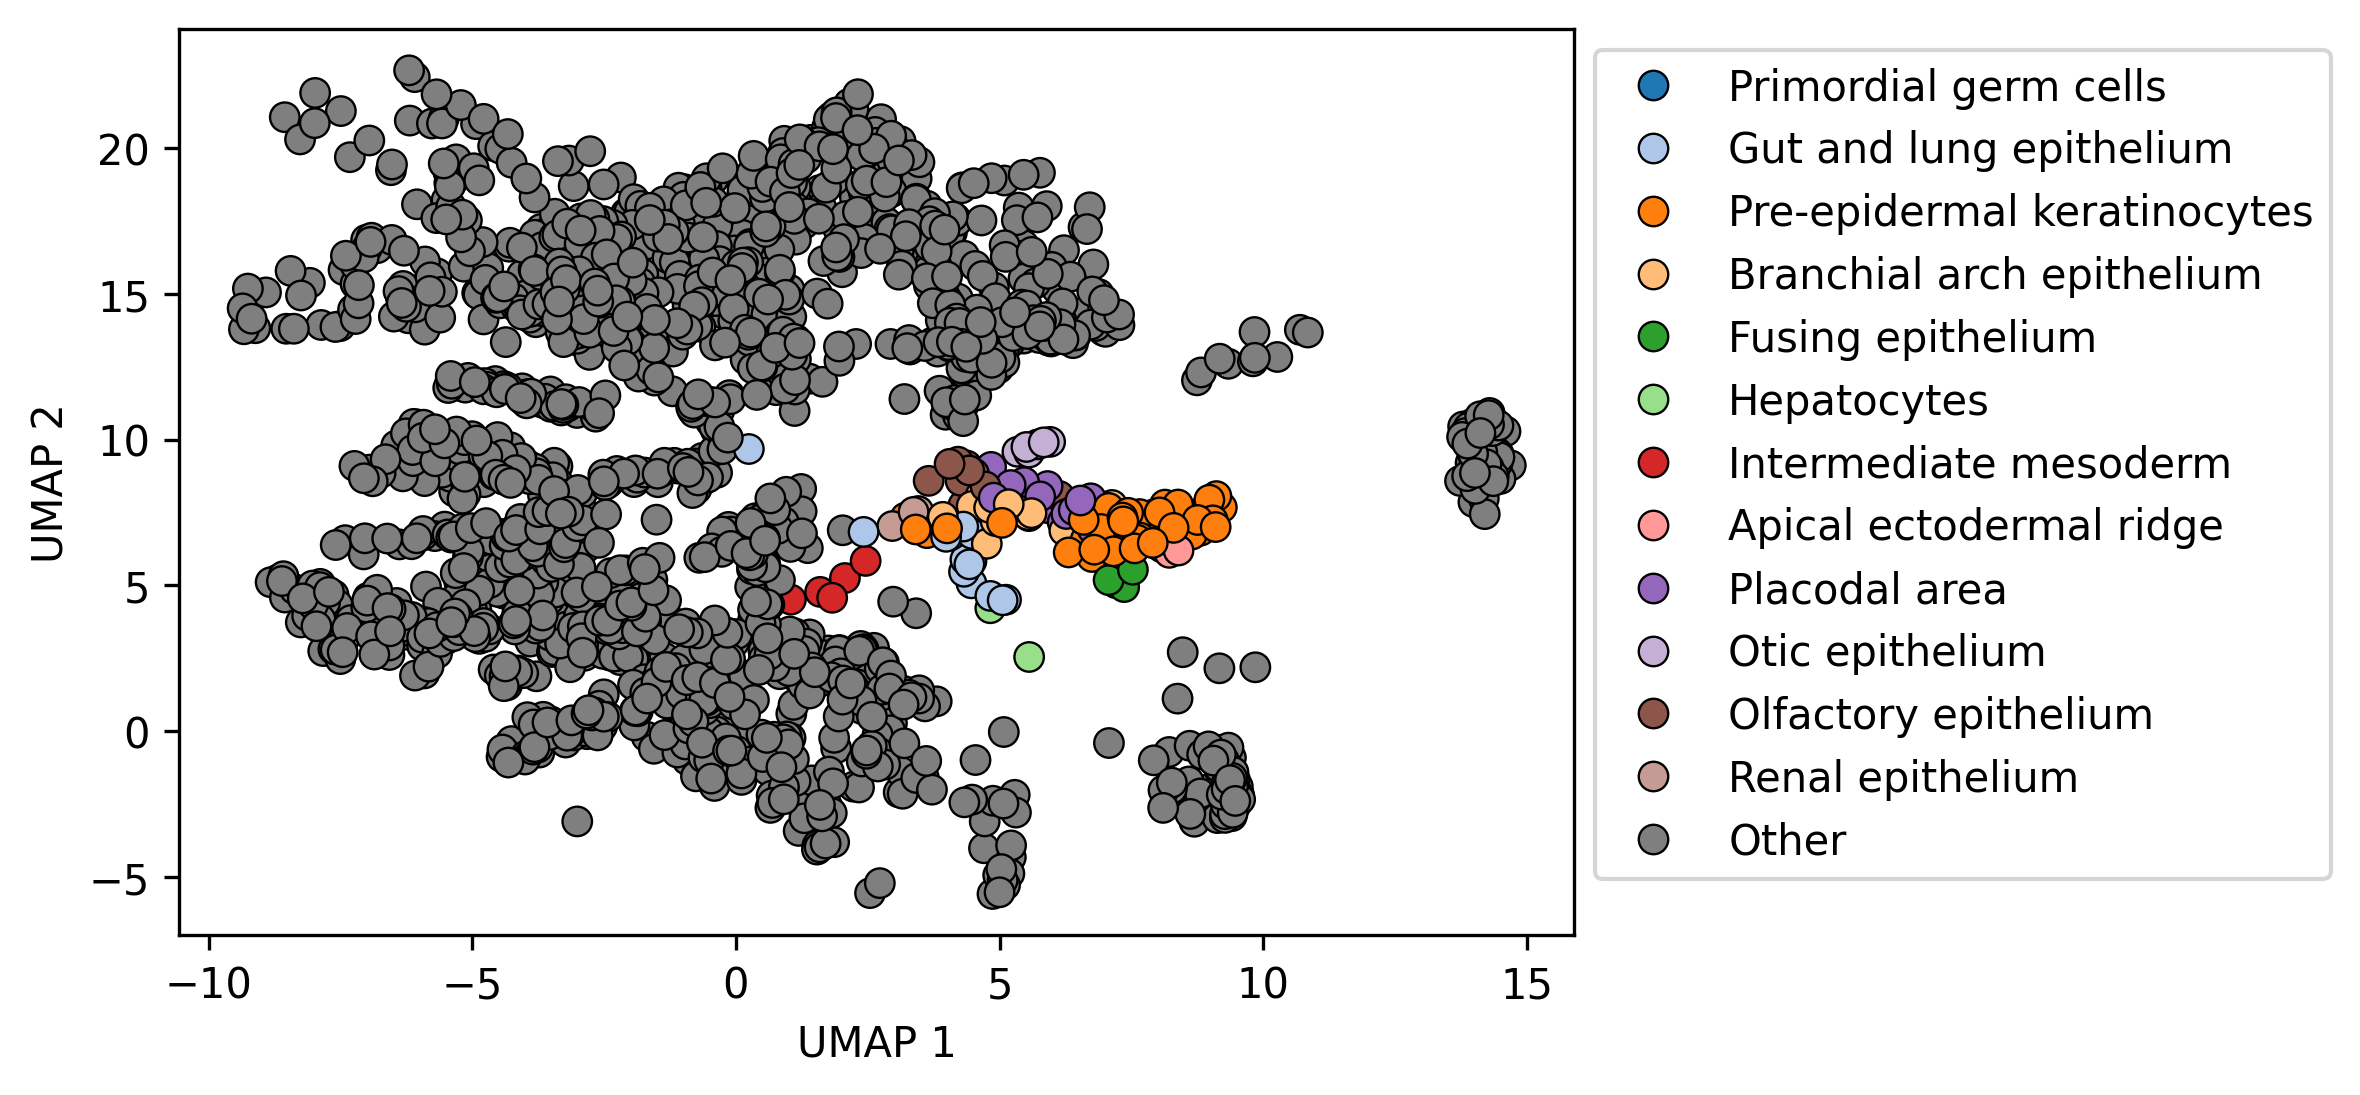

In [32]:
# for the palette
sns.scatterplot(data=ac.obs[ac.obs['set']=='metacells'], x='x', y='y', s=50, hue='Celltype', palette=palette, edgecolor='k')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

In [33]:
# And the zoom-in

/tmp/ipykernel_5543/3412757531.py:5: UserWarning: The palette list has more values (20) than needed (13), which may not be intended.
  sns.scatterplot(data=acs.obs[acs.obs['set']=='single_cell'], x='x', y='y', s=s0, hue='Celltype', palette=palette, legend=None)
/tmp/ipykernel_5543/3412757531.py:6: UserWarning: The palette list has more values (20) than needed (13), which may not be intended.
  sns.scatterplot(data=acs.obs[acs.obs['set']=='metacells'], x='x', y='y', s=s1, hue='Celltype', palette=palette, legend=None, edgecolor='k')


Text(0, 0.5, 'UMAP 2')

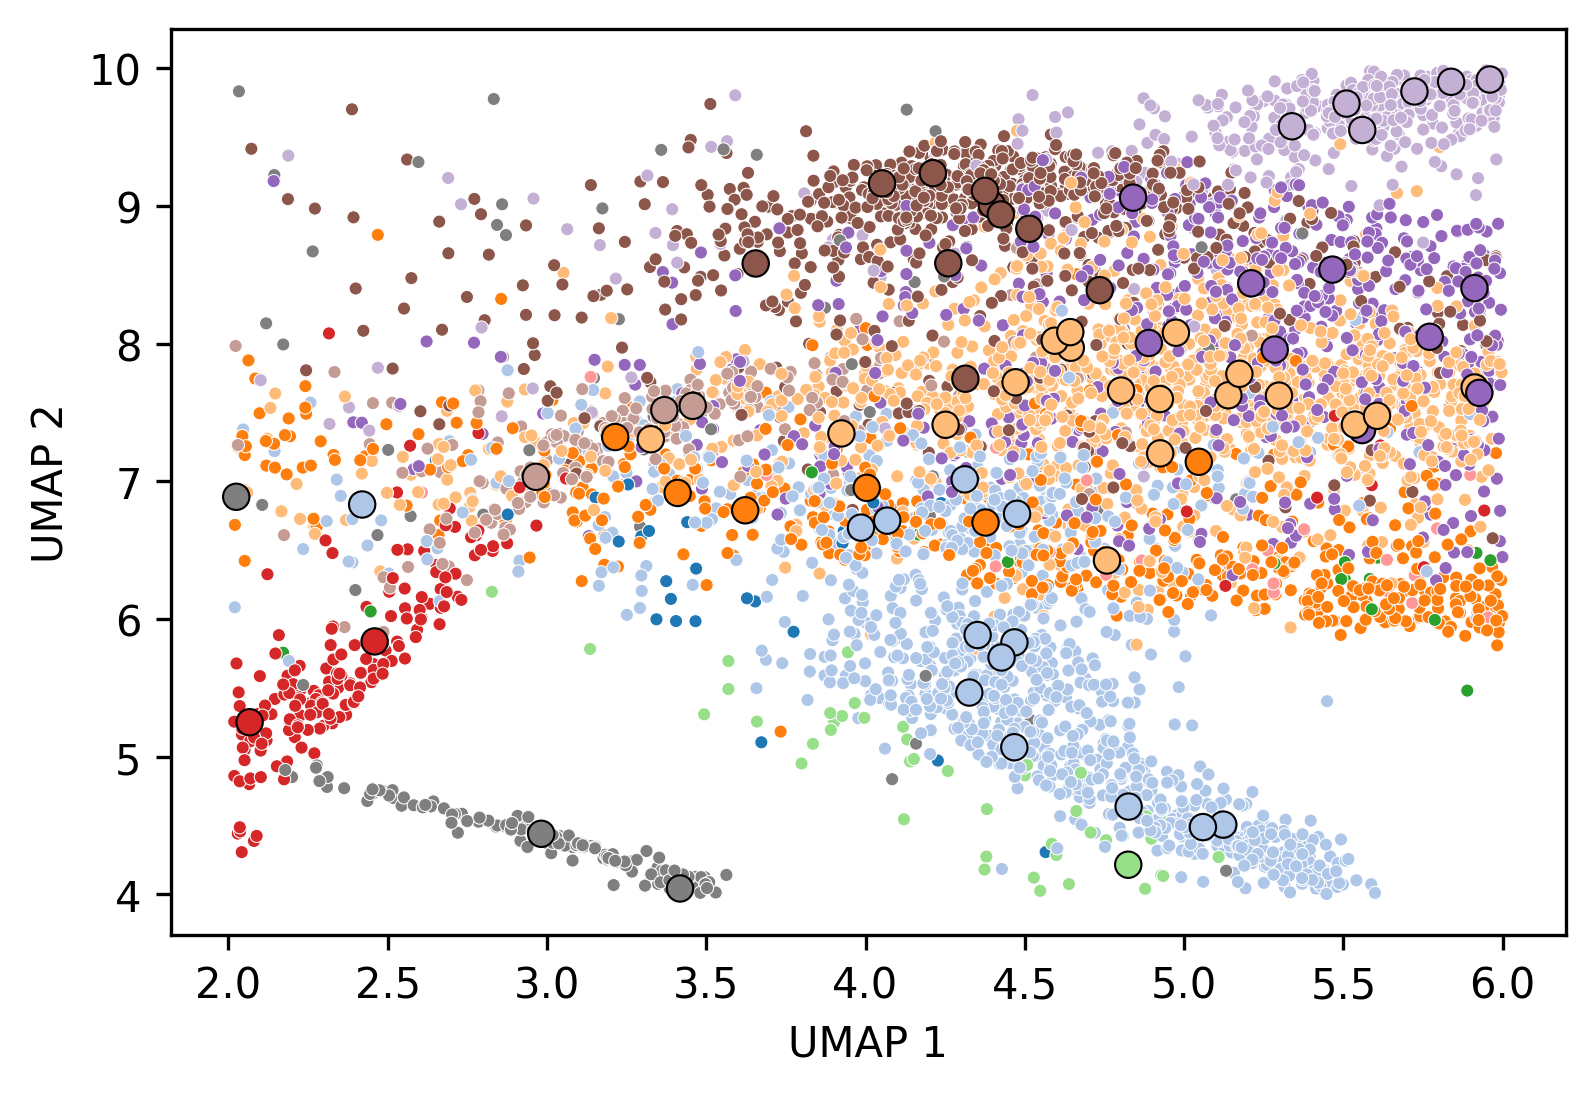

In [34]:
acs = ac[(ac.obs['x'].between(2,6))&(ac.obs['y'].between(4,10))].copy()
s0=10
s1=40

sns.scatterplot(data=acs.obs[acs.obs['set']=='single_cell'], x='x', y='y', s=s0, hue='Celltype', palette=palette, legend=None)
sns.scatterplot(data=acs.obs[acs.obs['set']=='metacells'], x='x', y='y', s=s1, hue='Celltype', palette=palette, legend=None, edgecolor='k')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

In [37]:
ob0['Celltype'] = [a if a in ct_keep else 'Other' for a in ob0['cell_type']]
ob0['Celltype'] = pd.Categorical(ob0['Celltype'], categories=ct_keep+['Other'], ordered=True)

In [38]:
# Is there a rare celltype that will be removed/downsampled highyly?

In [39]:
def get_dicts(ob):
    Ds = {}
    for s in sorted(set(ob['metacell'])):
        Ds[s]=[]
    for i,s in zip(ob.index, ob['metacell']):
        Ds[s].append(i)
    Dsi = dict(zip(ob.index, ob.metacell))
    return (Ds, Dsi)

In [40]:
Ds0, Ds0i = get_dicts(ob0)

In [41]:
# Get the celltypes for each metacell

In [42]:
D0_sc_to_inds = {}
for sc0 in tqdm(Ds0.keys()):
    D0_sc_to_inds[str(sc0)] = np.where(ob0.index.isin(Ds0[sc0]))[0]

100%|██████████████████████████████████████| 1972/1972 [00:07<00:00, 280.35it/s]


In [43]:
# Get the metacells for Primordial germ cells

In [44]:
ct = 'Primordial germ cells'
vc = ob0[ob0['cell_type']==ct]['metacell'].value_counts()
vc

metacell
1905    7
704     3
1762    2
908     2
1825    2
994     2
895     1
1718    1
29      1
1704    1
1753    1
453     1
1431    1
1865    1
1612    1
919     1
1112    1
980     1
Name: count, dtype: int64

In [45]:
mcs = list(vc.index)[:6]

In [46]:
frames=[]
for mc in mcs:
    dfn = pd.DataFrame(ob0[ob0['metacell']==mc]['Celltype'].value_counts())
    dfn['Celltype'] = dfn.index
    dfn['Metacell'] = mc
    frames.append(dfn)
Df = pd.concat(frames, ignore_index=True)
Df = Df.pivot(columns='Celltype', index='Metacell', values='count')
Df = Df.loc[mcs].copy()

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '1905'),
  Text(1, 0, '704'),
  Text(2, 0, '1762'),
  Text(3, 0, '908'),
  Text(4, 0, '1825'),
  Text(5, 0, '994')])

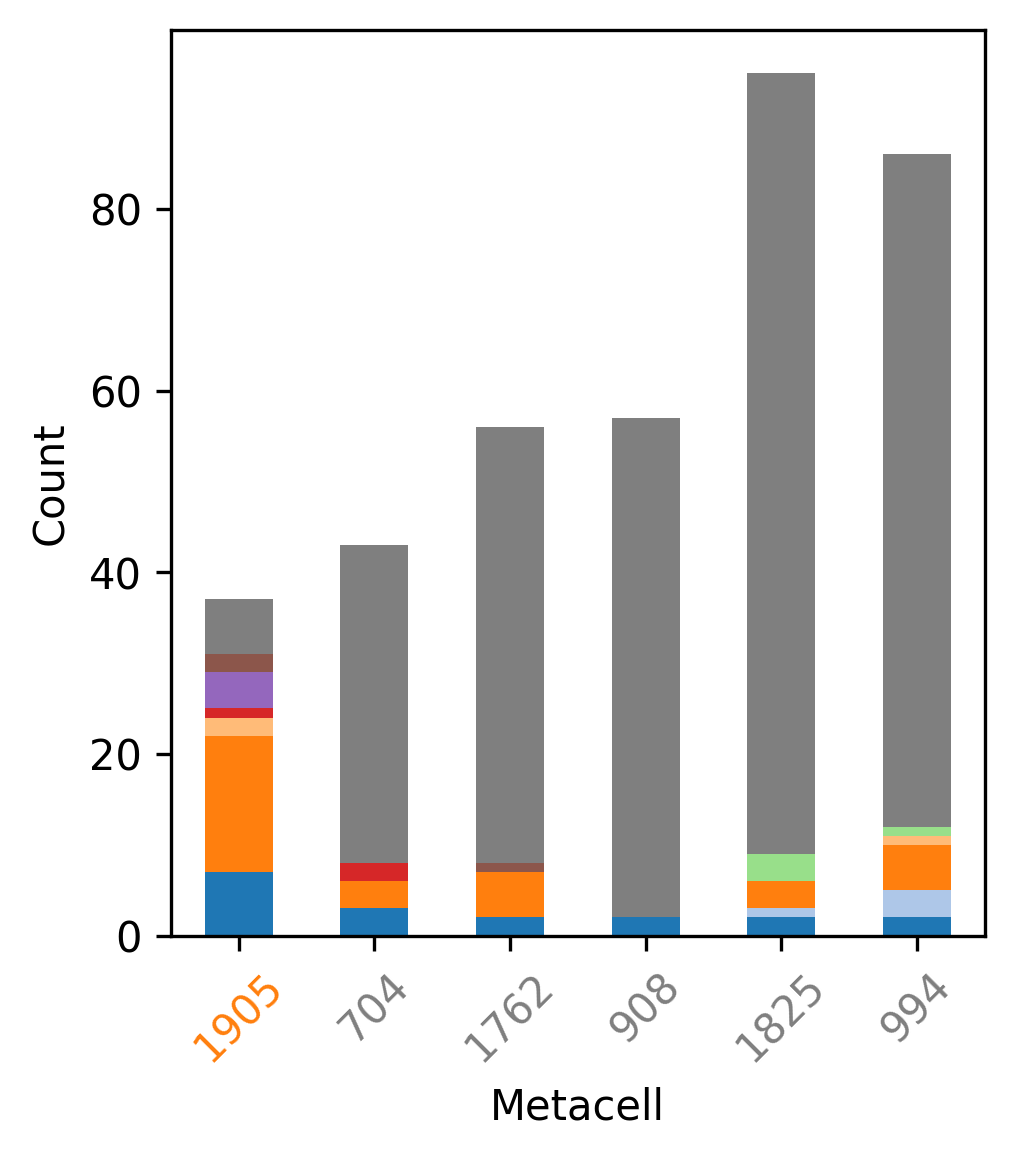

In [47]:
Df.plot(kind='bar', stacked=True, color=palette, legend=None, figsize=(3.5, 4))
plt.xlabel('Metacell')
plt.ylabel('Count')
ax = plt.gca()
l=0
for tick_label in ax.get_xticklabels():
    if l ==0:
        tick_label.set_color(palette[2])
        l=1
    else:
        tick_label.set_color(palette[12])
plt.xticks(rotation=45)

# E10.5 --> E11.5 transition score accuracy plots 

In [48]:
# And make the plots for the accuracy scores

In [49]:
vals = [0.779983, 0.964083, 0.756499, 0.956559]
method = ['moscot Single Cell', 'moscot Single Cell', 'moscot Metacell', 'moscot Metacell']
eval_type = ['curated transitions', 'germ layer transitions', 'curated transitions', 'germ layer transitions']
De = pd.DataFrame({'vals':vals, 'method':method, 'eval_type':eval_type})

In [50]:
pal=sns.color_palette('tab20')
pal[1]=pal[9]
pal[0]=np.array([13,111,178])/255

/tmp/ipykernel_5543/4247325592.py:1: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.barplot(data=De, x='eval_type', y='vals', hue='method', palette=pal)


(0.6, 1.0)

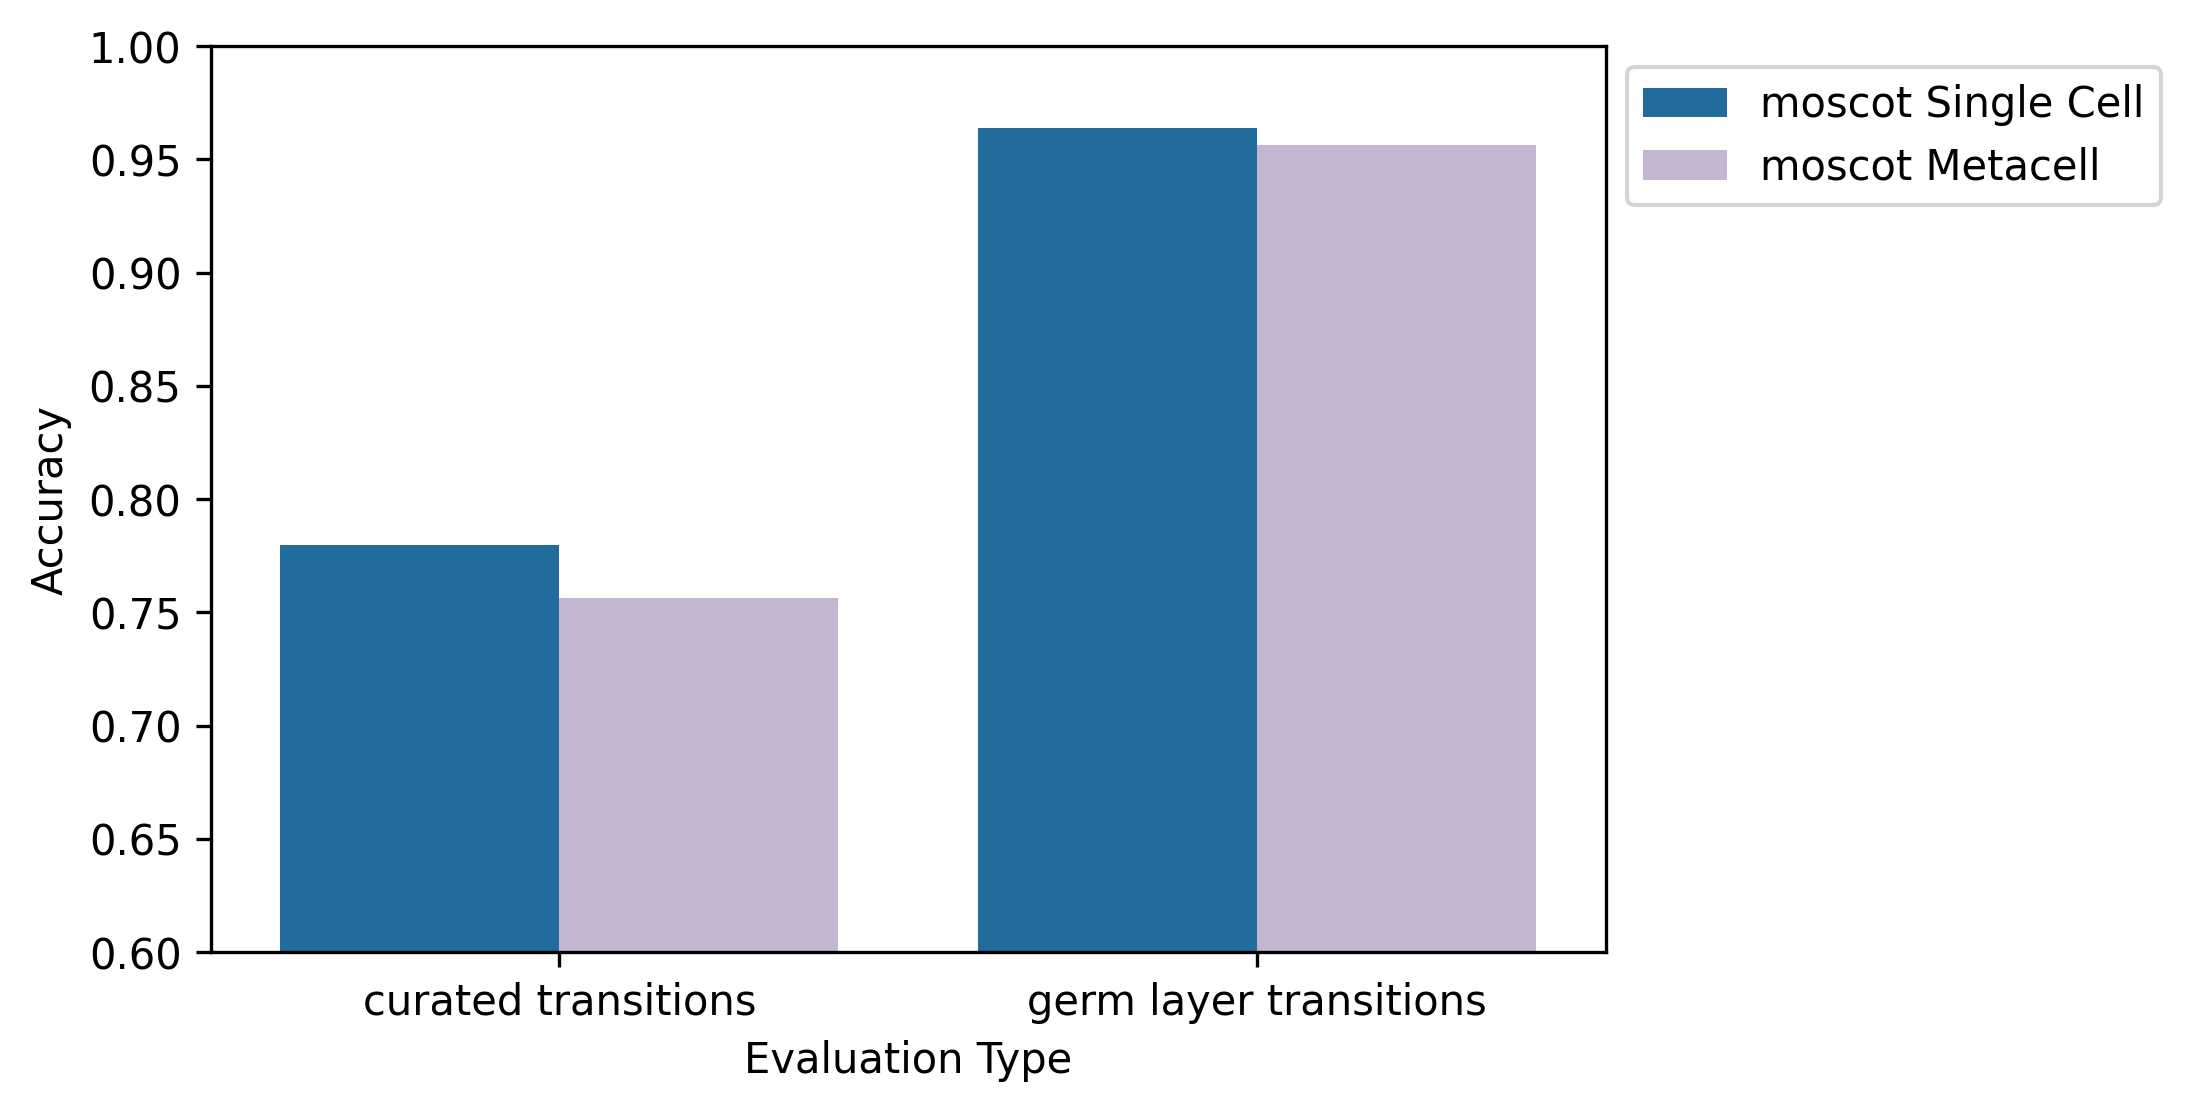

In [51]:
sns.barplot(data=De, x='eval_type', y='vals', hue='method', palette=pal)
plt.xlabel('Evaluation Type')
plt.ylabel('Accuracy')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0.6,1)

/tmp/ipykernel_5543/3149131771.py:1: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.barplot(data=De, x='eval_type', y='vals', hue='method', palette=pal)


(0.6, 1.0)

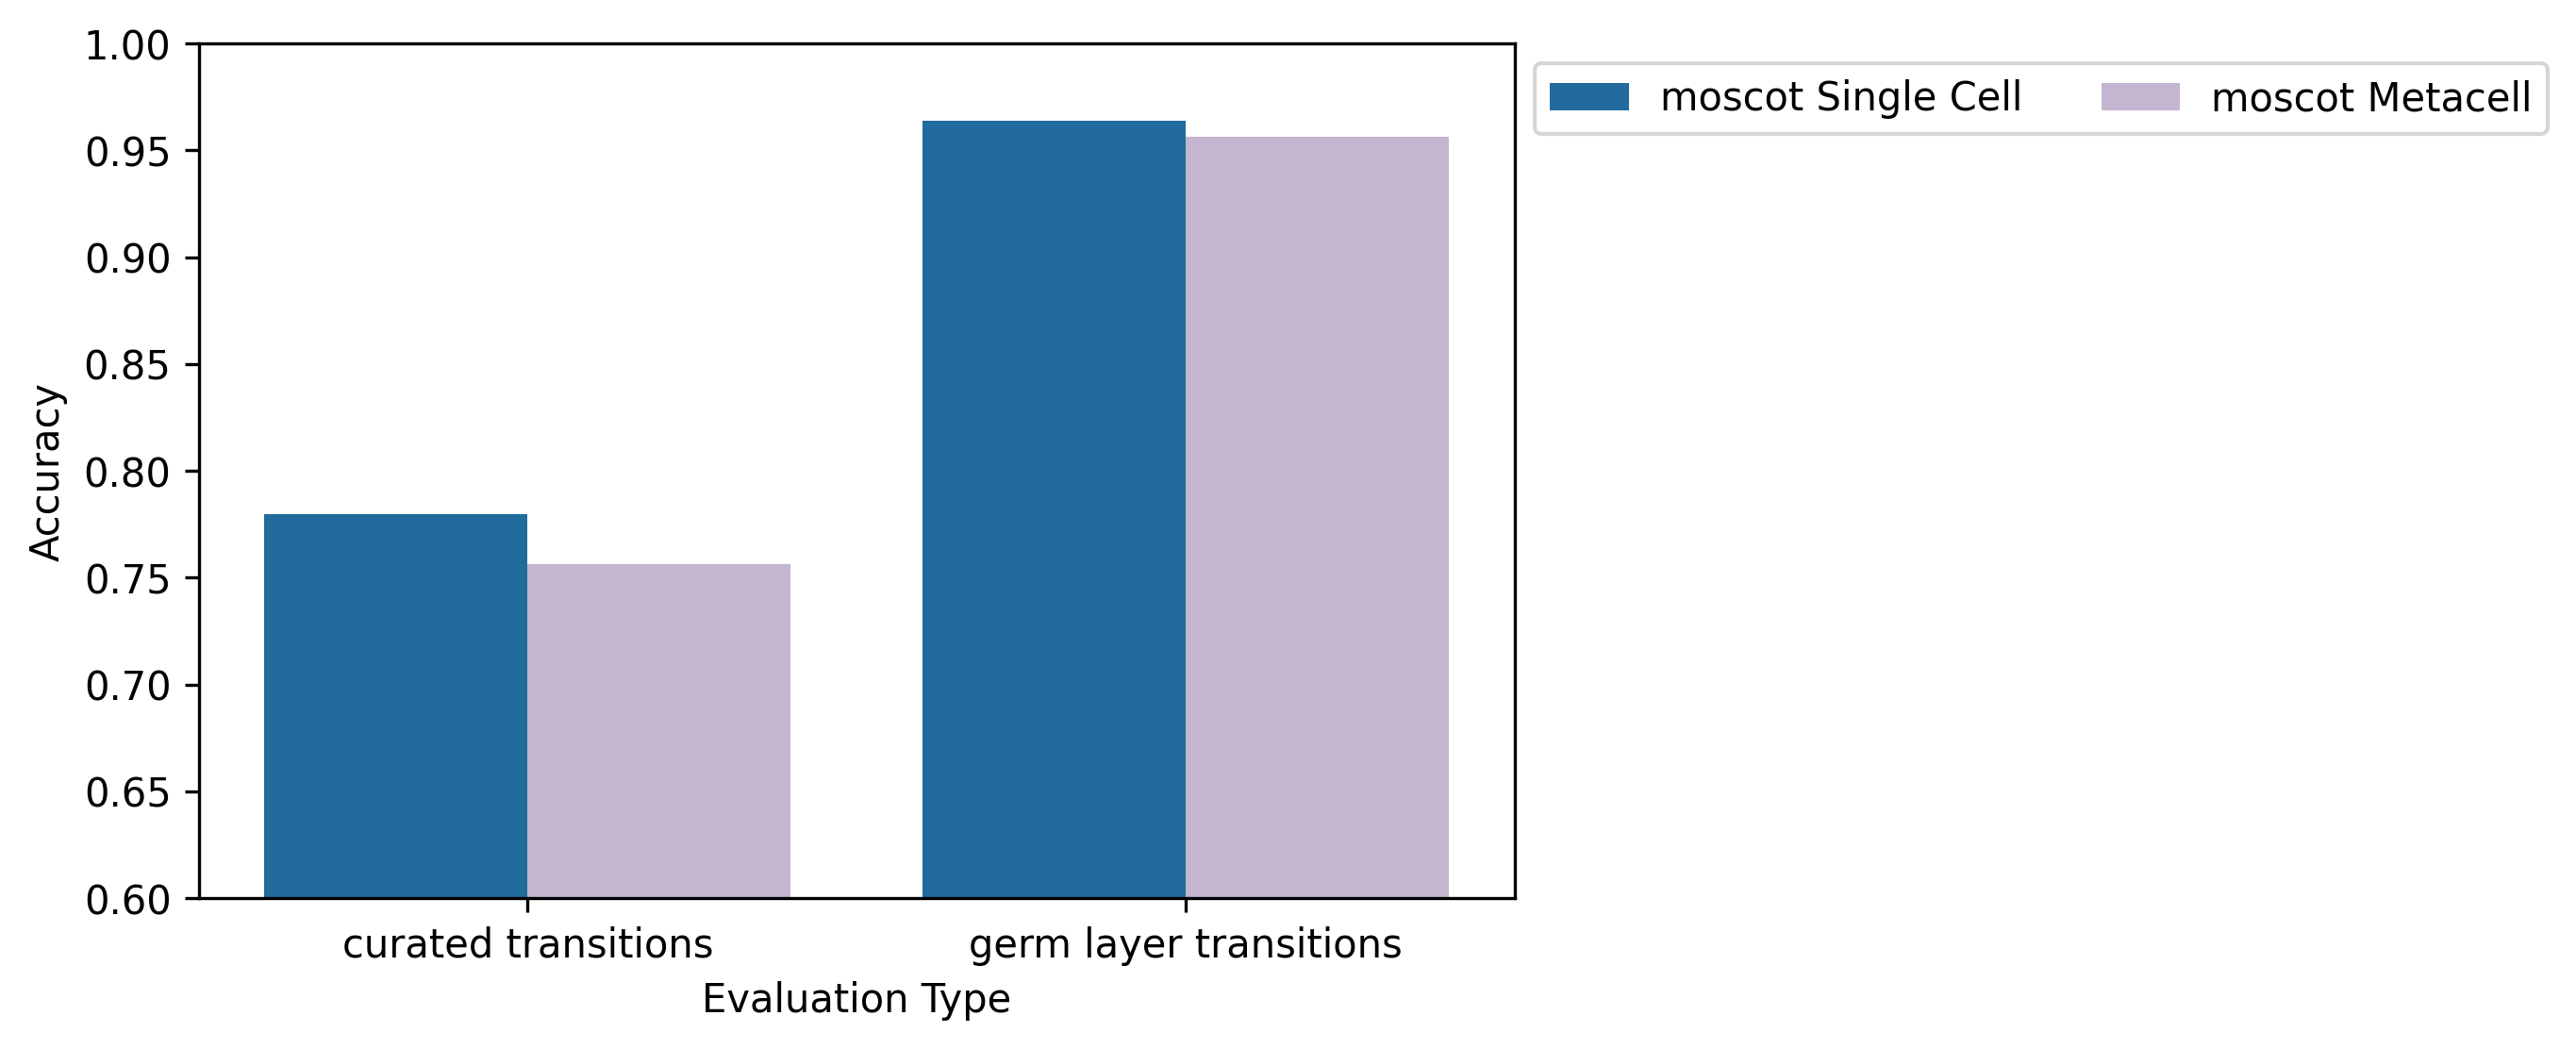

In [52]:
sns.barplot(data=De, x='eval_type', y='vals', hue='method', palette=pal)
plt.xlabel('Evaluation Type')
plt.ylabel('Accuracy')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
plt.ylim(0.6,1)

In [53]:
Dfm = pd.read_pickle('/home/manu/Downloads/Metacells_PE.npy')

/tmp/ipykernel_5543/4283808051.py:1: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.boxplot(data=Dfm, y='Abs. Correlation', hue='Method', palette=pal)


Text(0.5, 0, 'Correlation of Pull of Pancreatic Epithelium \n to Pancreatic Epithelium Driver Genes')

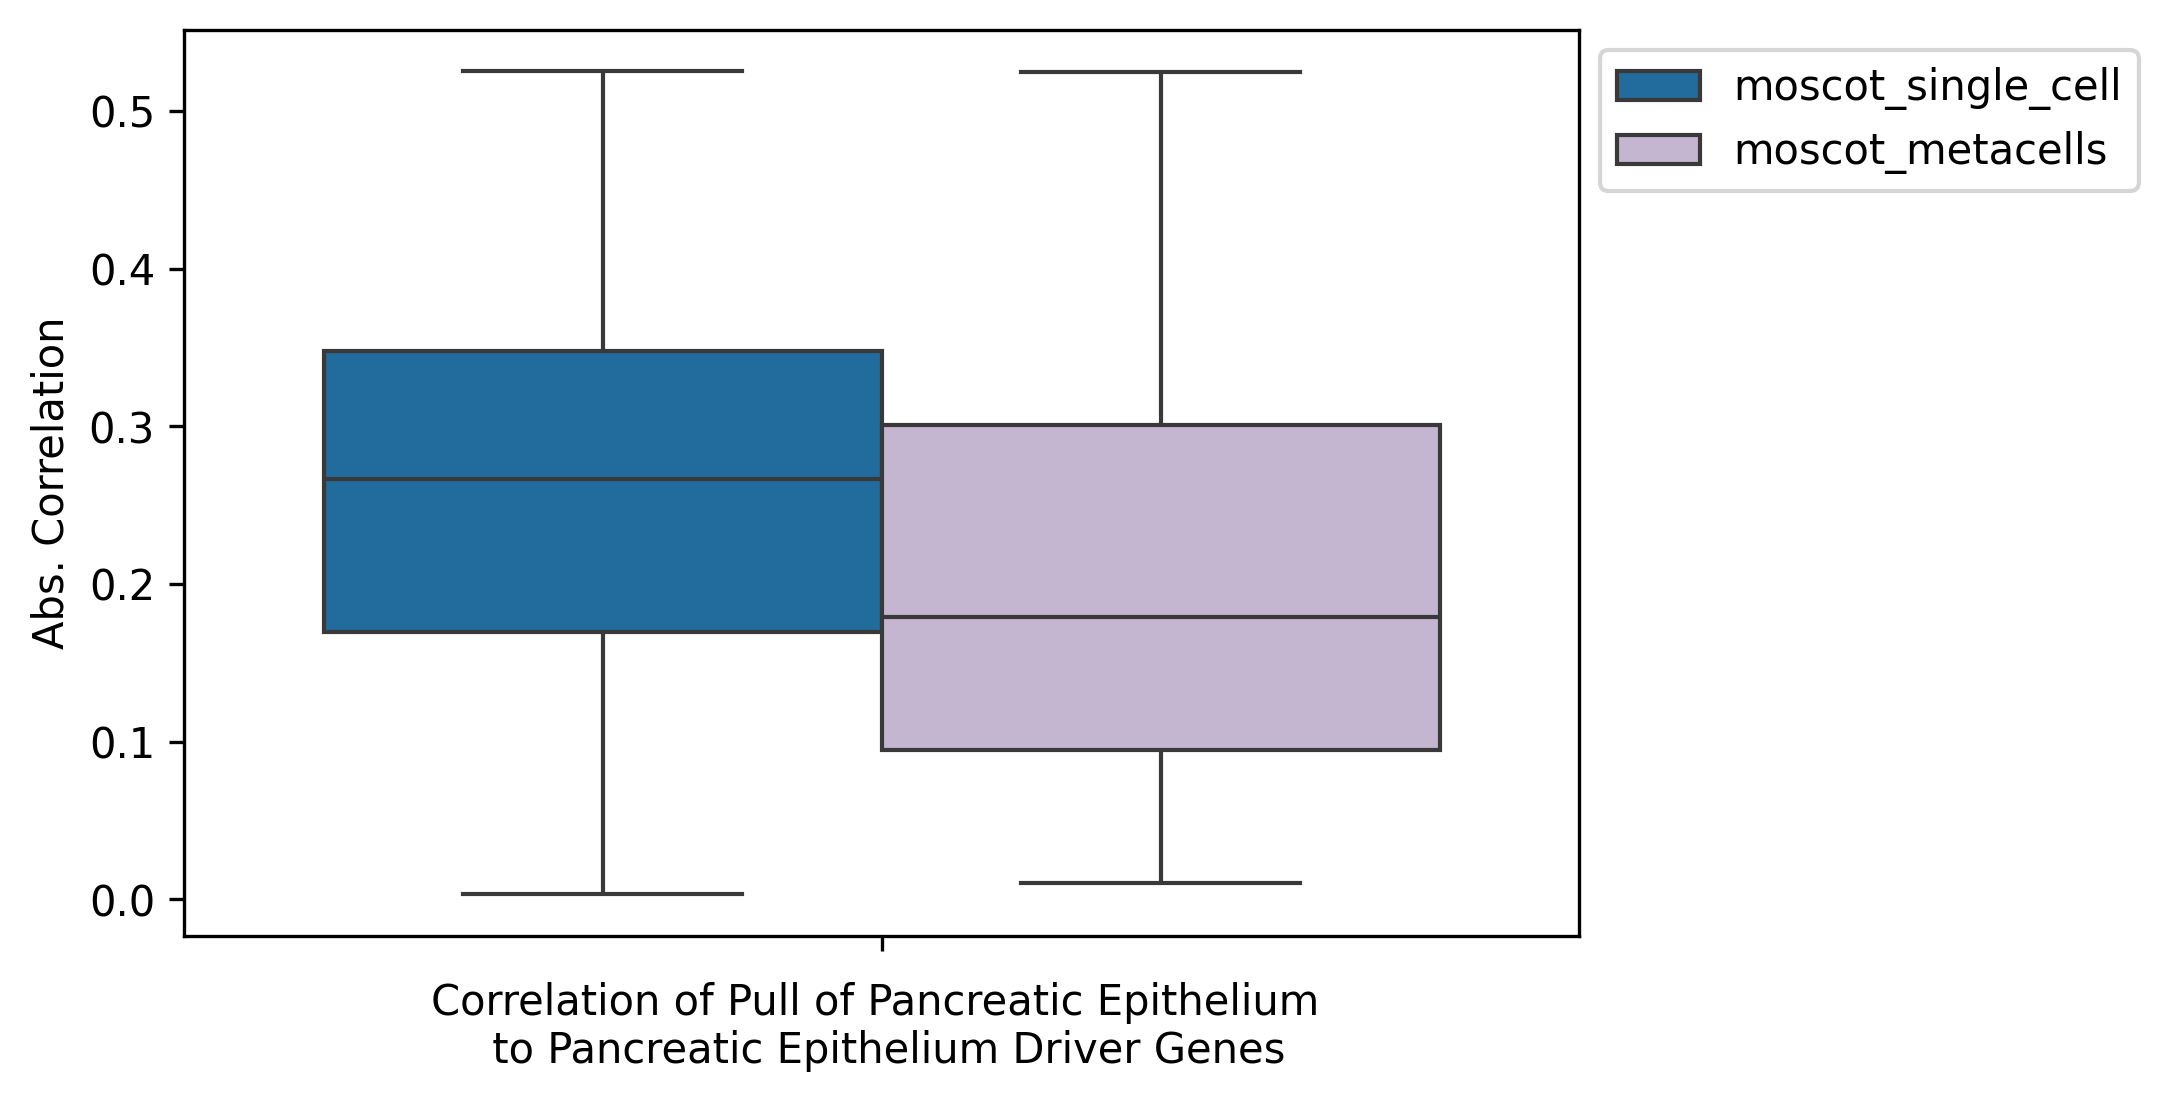

In [54]:
sns.boxplot(data=Dfm, y='Abs. Correlation', hue='Method', palette=pal)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Correlation of Pull of Pancreatic Epithelium \n to Pancreatic Epithelium Driver Genes')